In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm
from utils import rnmse
from torch.utils.data import DataLoader, TensorDataset
from sklearn.base import BaseEstimator
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.compose import TransformedTargetRegressor
from torch.utils.data import Subset
from neuralop import FNO
import pandas as pd
import seaborn as sns
import matplotlib
sns.set_style('whitegrid')
sns.set_context('notebook')
sns.set_palette('hot', n_colors=7)
plt.rc('text', usetex=True)      

font = {'family' : 'serif',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)

Error: trying to import DISCO convolutions without optional dependency torch-harmonics.  Please install with `pip install torch-harmonics` and retry.


In [2]:
x = torch.cat([torch.load("../dataset/x_train.pt"), torch.load("../dataset/x_train_2.pt")])
y = torch.cat([torch.load("../dataset/y_train.pt"), torch.load("../dataset/y_train_2.pt")])
c = torch.cat([torch.load("../dataset/c_train.pt"), torch.load("../dataset/c_train_2.pt")])

x_test = torch.load("../dataset/x_test.pt")
y_test = torch.load("../dataset/y_test.pt")
c_test = torch.load("../dataset/c_test.pt")

In [3]:
x_np, y_np, c_np = x.numpy(), y.numpy(), c.numpy()
x_np_reshaped, y_np_reshaped, c_np_reshaped = x_np.reshape((x_np.shape[0], -1)), y_np.reshape((y_np.shape[0], -1)), c_np.reshape((c_np.shape[0], -1))
x_test_np, y_test_np, c_test_np = x_test.numpy(), y_test.numpy(), c_test.numpy()
x_test_np_reshaped, y_test_np_reshaped, c_test_np_reshaped = x_test_np.reshape((x_test_np.shape[0], -1)), y_test_np.reshape((y_test_np.shape[0], -1)), c_test_np.reshape((c_test_np.shape[0], -1))

In [8]:
class DoNothingRegressor(BaseEstimator):
    def __init__(self):
        pass
    def fit(self, X, y):
        pass
    def predict(self, X):
        return np.zeros_like(X)

In [9]:
n_components = 64
class ResidualRegressor(BaseEstimator):
    def __init__(self, regressor, n_components=64):
        self.n_components = n_components
        self.pipe_lm = TransformedTargetRegressor(
            regressor=Pipeline([
                ("pca", PCA(n_components=self.n_components)),
                ("lm", LinearRegression(n_jobs=-1))
            ]),
            transformer=PCA(n_components=self.n_components),
            check_inverse=False
        )
        self.regressor = regressor

    def fit(self, X, y):
        self.pipe_lm.fit(X, y)
        y_hat_lm = self.pipe_lm.predict(X)
        self.regressor.fit(X, y-y_hat_lm)

    def predict(self, X):
        return self.regressor.predict(X) + self.pipe_lm.predict(X)

In [5]:
def scorer_rnmse(estimator, x, y):
    return rnmse(estimator.predict(x), y)

In [6]:
n_points = x.shape[0]

In [10]:
model = ResidualRegressor(DoNothingRegressor())
model.fit(x_np_reshaped[:n_points], y_np_reshaped[:n_points])

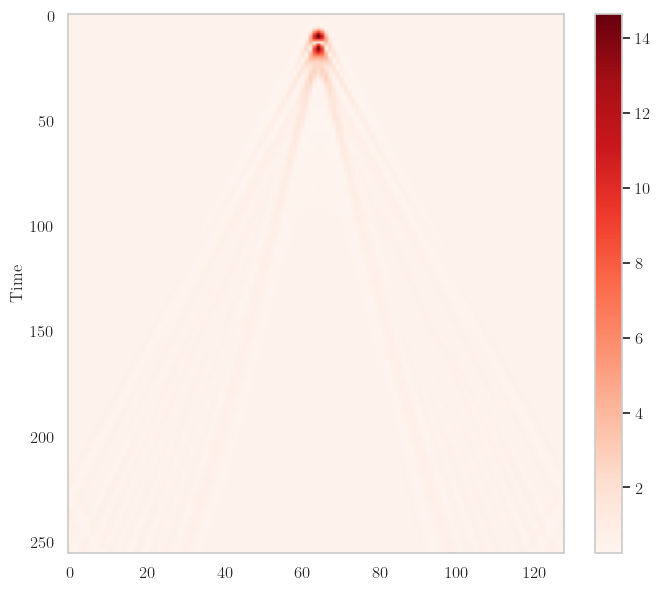

In [11]:
inputs = np.random.random(size=(5192, *x_np_reshaped.shape[1:]))
outputs = model.predict(inputs)
to_plot = (np.mean(np.abs(inputs-outputs), axis=0)).reshape(*x_np.shape[1:])
plt.figure(figsize=(8, 7))
plt.imshow(to_plot, aspect='auto', cmap='Reds')
plt.grid(False)
plt.colorbar()
plt.ylabel("Time")
plt.savefig('average_correction.jpg', dpi=150)
plt.show()